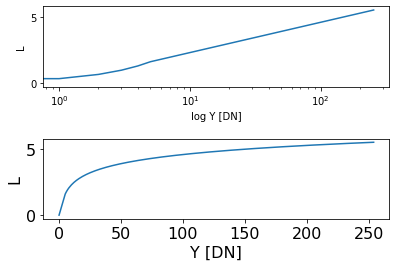

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from src.emulator import lin_log

y=np.array(range(255), float)
l=lin_log(y,threshold=5)

fnt=16
plt.subplot(211)
plt.rcParams.update({'font.size': fnt})
plt.plot(y,l)
plt.xlabel('log Y [DN]')
plt.ylabel('L')
plt.tight_layout()
plt.xscale('log')

plt.subplot(212)
plt.rcParams.update({'font.size': fnt})
plt.plot(y,l)
plt.xlabel('Y [DN]')
plt.ylabel('L')
plt.tight_layout()
plt.xscale('linear')

plt.savefig('../output/linlog.pdf')
plt.savefig('../media/linlog.png')




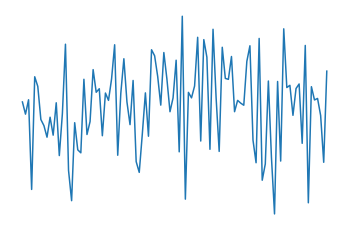

In [2]:
import numpy as np
from matplotlib import pyplot as plt

t=np.array(range(100),float)
n=np.random.randn(len(t))
fig=plt.figure(3)
plt.plot(t,n)
plt.axis('off')
plt.savefig('../output/noise.pdf')

In [3]:
# compute the expected number of temporal noise events per sample for a
# given sigma of gaussian noise sig and threshold th
import numpy as np
from math import erf, sqrt
# https://docs.python.org/3.2/library/math.html
def phi(x):
    'Cumulative distribution function for the standard normal distribution'
    return (1.0 + erf(x / sqrt(2.0))) / 2.0

RnHzDesired=0.1 # desired rate of noise events per second
fsHz=100 # sample rate Hz
theta=.15 # event threshold in log_e units, but it doesn't matter what it is
# dumb search for best sigma
for sig in np.linspace(0,theta,1000):
    n=0
    for k in range(1,100):
        th0=k*theta
        th1=(k+1)*theta
        n+=k*(phi(th1/sig)-phi(th0/sig)) # weight expected # events times probability       
        Rn=fsHz*n
    if Rn>RnHzDesired:
        print('sig={:6.2f}\tn={:8.3g}ev/samp\tRn={:8.3g}ev/s'.format(sig,n,Rn))
        print('desired rate: {}'.format(RnHzDesired))
        break
 

sig=  0.05	n= 0.00102ev/samp	Rn=   0.102ev/s
desired rate: 0.1


/home/tobi/anaconda3/envs/pt-v2e/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


In [6]:
import numpy as np
cutoffhz=10.
tau=1/(2*np.pi*cutoffhz)
fs=300.
dt=1/fs
eps=dt/tau



In [ ]:
import numpy as np
f3dbhz=100.
f=np.logspace(-2,4,100)
s=2*np.pi*f
tau=1/(2*np.pi*f3dbhz)
a=tau*s+1
b=a*a
h=np.reciprocal(b)

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})

fig=plt.figure(5)
plt.plot(f,h)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('|H|')
plt.savefig('../output/lowpass.pdf')

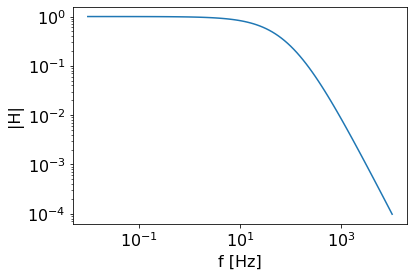

In [8]:
import numpy as np
f3dbhz=100.
f=np.logspace(-2,4,100)
s=2*np.pi*f
tau=1/(2*np.pi*f3dbhz)
a=tau*s+1
b=a*a
h=np.reciprocal(b)

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})

fig=plt.figure(5)
plt.plot(f,h)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('|H|')
plt.savefig('../output/lowpass.pdf')

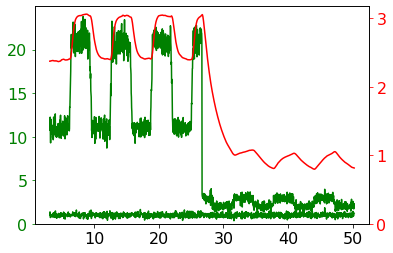

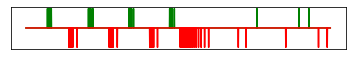

In [127]:
import numpy as np
from scipy.signal import square

dark=1 # dark current level
sigdc1=10 # DC photocurrent for bright half
sigdc2=1 # and dark half
cont=1 # contrast in each half
tau=.2 # time constant of lowpass
nper=4 # how many periods to simulate for each half
thr=.1 # dvs threshold

dt=np.pi/100
eps=dt/tau
t=np.arange(np.pi,nper*2*2*np.pi,dt)
npts=len(t)
npts2=int(npts/2)
sq=(square(t)+1)/2
sq=np.convolve(sq,np.ones(10)/10,mode='same')


sig=np.zeros_like(sq)
sig[:npts2]=sigdc1*(1+cont*sq[:npts2])
sig[npts2:]=sigdc2*(1+cont*sq[npts2:])

noiseFactor=.2
noise=noiseFactor*np.random.randn(t.shape[0])*np.sqrt(sig)
sig=sig+noise
darknoise=dark+noiseFactor*np.random.randn(t.shape[0])*np.sqrt(dark)

cur=sig+darknoise
logcur=np.log(cur)
ph1=np.zeros_like(logcur)
sf=np.zeros_like(logcur)
ph1[0]=logcur[0]
sf[0]=logcur[0]
for i in range(0,len(t)-1):
    tauactual=tau*max(cur)/cur[i]
    e=dt/tauactual
    ph1[i+1]=(1-e)*ph1[i]+e*logcur[i]
    sf[i+1]=(1-eps)*sf[i]+eps*ph1[i]

# include DVS events
lmem=sf[0]
ons=np.zeros_like(t)
offs=np.zeros_like(t)
for i in range(1,len(t)):
    if sf[i]-lmem>=thr:
        ons[i]=1
        lmem=sf[i]
    elif sf[i]-lmem<=-thr:
        offs[i]=-1
        lmem=sf[i]
        
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})

fig,ax1=plt.subplots(sharex=True)
ax1.plot(t,cur,'g',t,darknoise,'g')
ax1.set_ylim([0,None])
ax1.set_yscale('linear')
ax1.set_xscale('linear')
ax1.tick_params(axis='y', colors='green')

ax2=ax1.twinx()
ax2.plot(t,sf,'r-')

ax2.set_ylim([0,None])
ax2.set_yscale('linear')
ax2.set_xscale('linear')
ax2.tick_params(axis='y', colors='red')

fig,ax3=plt.subplots(sharex=True)
offset=8
ax3.plot(t,offset+ons,'g', t,offset+offs,'r')
ax3.get_xaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])
ax3.set_aspect(3)


# plt.xlabel('t [s]')
# plt.ylabel('[log]')
# plt.grid('on')


plt.savefig('../output/photo_dark_lowpass_curves.pdf')




In [111]:
f=2.8 # focal length
T=0.9 # lens transmittance
R=.18 # avg scene reflectance
lchip=np.logspace(0,4,5,endpoint=True)
factor=(4*f**2/T/R)
lscene=factor*lchip
print(lchip)
print(lscene)


[1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
[1.93580247e+02 1.93580247e+03 1.93580247e+04 1.93580247e+05
 1.93580247e+06]
